# Authentication

In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd "/gdrive"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import os 
os.chdir("/gdrive/My Drive/exercise/")

In [ ]:
!ls

# Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
import keras
from keras.models import Sequential, load_model
from keras import layers

from keras.callbacks import EarlyStopping

from keras.datasets import mnist

# Preprocess Data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


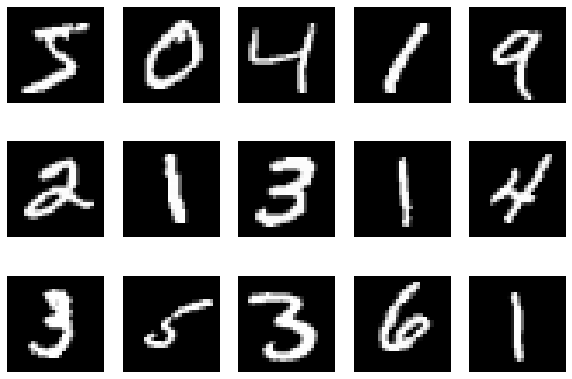

In [7]:
plt.figure(figsize=(10, 7))

for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")



In [8]:
X_train = X_train.reshape(-1,28, 28, 1).astype("float32")
X_test = X_test.reshape(-1, 28, 28, 1).astype("float32")

X_train /= 255
X_test /=255

In [9]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# Create Model

In [11]:
model = Sequential()

model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
  
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [13]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train Model

In [14]:
batch_size = 16
epochs = 6

In [15]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [16]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], validation_data=(X_test, y_test))

Epoch 1/6
3750/3750 [==============================] - 54s 6ms/step - loss: 0.1257 - accuracy: 0.9610 - val_loss: 0.0561 - val_accuracy: 0.9804
Epoch 2/6
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.0382 - val_accuracy: 0.9882
Epoch 3/6
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0359 - accuracy: 0.9902 - val_loss: 0.0305 - val_accuracy: 0.9912
Epoch 4/6
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0313 - accuracy: 0.9914 - val_loss: 0.0452 - val_accuracy: 0.9870
Epoch 5/6
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0281 - accuracy: 0.9930 - val_loss: 0.0394 - val_accuracy: 0.9892
Epoch 6/6
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0268 - accuracy: 0.9935 - val_loss: 0.0383 - val_accuracy: 0.9908


# Evaluate Model

In [17]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.125697,0.961000,0.056100,0.9804
1,0.044251,0.986933,0.038193,0.9882
2,0.035913,0.990167,0.030473,0.9912
3,0.031341,0.991383,0.045245,0.9870
4,0.028068,0.992983,0.039374,0.9892
5,0.026847,0.993533,0.038312,0.9908


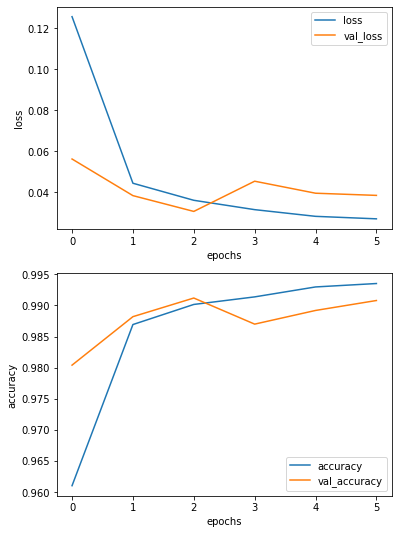

In [18]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(range(len(loss_df)), loss_df["loss"], label="loss")
plt.plot(range(len(loss_df)), loss_df["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(loss_df)), loss_df["accuracy"], label="accuracy")
plt.plot(range(len(loss_df)), loss_df["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [19]:
scores = model.evaluate(X_test, y_test)

print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0383 - accuracy: 0.9908
Test Loss: 0.03831205889582634
Test Accuracy: 0.9908000230789185


# Save Model

In [20]:
#model.save("save_models/mnist_model.h5")
loaded_model = load_model("save_models/mnist_model.h5")


# Predictions

In [21]:
new_image = X_test[22].reshape(-1, 28, 28, 1)
y_test[22]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

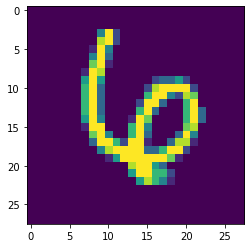

In [22]:
plt.imshow(new_image.reshape(28, 28))

In [23]:
pred = loaded_model.predict(new_image)
pred.argmax()

6